In [10]:
os.getcwd()

'/home/onyxia/work/detection-habitat-spontane'

In [11]:
os.chdir("src/")

In [18]:
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 3.0 MB/s eta 0:00:0000:0100:01


In [77]:
import gc
import os
import sys
from datetime import datetime

#import mlflow
import numpy as np
#import pytorch_lightning as pl
import torch
import yaml

from train_pipeline_utils.download_data import load_pleiade_data
from utils.utils import update_storage_access
from classes.data.satellite_image import SatelliteImage
from PIL import Image
import pyproj
from pyproj import Transformer
import re
import matplotlib.image

In [25]:
load_pleiade_data(2019,"976")

download 976 2019 in /home/onyxia/work/detection-habitat-spontane/data/PLEIADES/2019/MAYOTTE


'/home/onyxia/work/detection-habitat-spontane/data/PLEIADES/2019/MAYOTTE'

In [51]:

#crs = 5490 pour la martinique
def gps_to_crs_point(lat,lon,crs) :
    
    # coordinate  = (-12.789072624567547, 45.21788967618977)
    # lat, lon = coordinate
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:"+ str(crs))

    # Convertir les coordonnées GPS en coordonnées dans le système de coordonnées de destination (CRS)
    x, y = transformer.transform(lat, lon)
    
    # Retourner les coordonnées dans le CRS spécifié
    return x, y

#ca serait bien de faire une fonction qui cherche dans l'ensemble des données l'image qui contiendra cette coordonées.

def find_image_of_point(coordinate, folder_path, coord_gps = False, crs = None) :
        
    if coord_gps == True :  
        lat, lon = coordinate
        x,y = gps_to_crs_point(lat,lon,crs) #car y=lat et x=lon, les coordonnées gps sont en (lat,lon)
    else :
        x,y = coordinate
                                          
    for filename in os.listdir(folder_path):
        
        # Define a list of delimiter characters
        delimiters = ["-", "_"]

        # Create a regular expression pattern from the delimiter characters
        pattern = "|".join(delimiters)

        # Split the string using the regular expression pattern
        split_filename = re.split(pattern, filename)
        
        left = float(split_filename[2])*1000
        top = float(split_filename[3])*1000
        right = left + 1000.0
        bottom = top - 1000.0
         
        if left <= x <= right:
            if bottom <= y <= top:
                return(folder_path + '/' +filename)
    else : 
        return("Le point n'est pas retrouvé dans ce fichier d'images")
           


In [43]:
dir = "/home/onyxia/work/detection-habitat-spontane/data/PLEIADES/2019/MAYOTTE/"


'/home/onyxia/work/detection-habitat-spontane/data/PLEIADES/2019/MAYOTTE/ORT_2019_0518_8573_U38S_8Bits.jp2'

In [93]:
coordinate  = (-12.789058574337282, 45.141467900587855)

coord_gps = True
path_t = find_image_of_point(
                                   coordinate,
                                   dir,
                                   coord_gps,
                                    crs = 4471
                                  )
path_t

'/home/onyxia/work/detection-habitat-spontane/data/PLEIADES/2019/MAYOTTE//ORT_2019_0515_8587_U38S_8Bits.jp2'

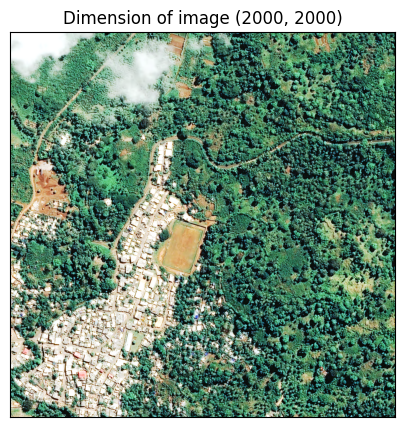

In [94]:
im = SatelliteImage.from_raster(
        path_t,
        dep = "976",
        date = None, 
        n_bands = 3
    )
    
im.plot([0,1,2])
im = SatelliteImage.from_raster( # pour eviter la normalisation
        path_t,
        dep = "976",
        date = None, 
        n_bands = 3
    )
    

In [95]:
filename = "MAYOTTE-ORT_2019_0515_8587_U38S_8Bits"
matplotlib.image.imsave(filename + ".jpg", np.transpose(im.array,[1,2,0]))

## lecture des retours label studio

In [7]:
import os
import zipfile
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np


def create_mask_from_label_studio_export(
    num_task,
    name_output,
    type_label="Petites habitations",
    emplacement_zip="../labelstudio.zip",
):
    """
    Extracts binary masks for a single type label from a Label Studio
    export file, combines them into a single mask,
    and saves it as a numpy file.
    Args:
        num_task (str):
            The task number to select masks from.
        name_output (str):
            The file path to save the output numpy file.
            Enter the same name as the image where the mask comes from.
        type_label (str):
            The type of label to select masks for.
            Default is 'Petites habitations'.
        emplacement_zip (str):
            The file path of a zipped Label Studio export file.
            Default is '../labelstudio.zip'.
    Returns:
        Plot of the mask.
    Example:
    >>> create_mask_from_label_studio_export(
            num_task = "1",
            name_output = "mayotte2020nomfichier"
        )
    """
    with zipfile.ZipFile(emplacement_zip, "r") as zip_ref:
        zip_ref.extractall("labelstudio")

    dir = "labelstudio/"

    liste_name = os.listdir(dir)

    list_num_task = [file.split("-")[1] for file in liste_name]
    list_type_label = [file.split("-")[7] for file in liste_name]

    booleen = [
        nt == num_task and tl == type_label
        for nt, tl in zip(list_num_task, list_type_label)
    ]

    list_name_select = [name for name, b in zip(liste_name, booleen) if b]
    list_path_mask = [dir + name for name in list_name_select]

    list_mask = [np.load(path) for path in list_path_mask]
    mask = reduce(lambda x, y: x + y, list_mask)

    mask[mask != 0] = 1

    # Plot the mask using imshow
    plt.imshow(mask, cmap="gray", interpolation="nearest")

    # Show the plot
    plt.show()

    np.save(name_output, mask)